# Local Quantile Projections: Example

This notebook presents a (simple) application of local quantile projections

It uses a Python package that I have written, quantileproj.py, also available in this Github folder (modules/). quantileproj is based on the Quantreg modules of statsmodels. The package also relies on my conditional quantile sampling module (https://github.com/romainlafarguette/cqsampling)

The quantile uncrossing part is based on either:

Chernozhukov et al. (2010) Quantile and Probability Curves Without Crossing, Econometrica

Schmidt and Zhu (2016), Quantile Spacings: A Simple Method for the Joint Estimation of Multiple Quantiles Without Crossing

Author: Romain Lafarguette, August 2020, https://github.com/romainlafarguette

If you have any question, please contact me via Github 

## Preamble

In [1]:
# Main packages
import os, sys, importlib                               # System tools
import pandas as pd                                     # Dataframes
import numpy as np                                      # Numeric tools
import statsmodels.api as sm                            # Statistics

# Graphics
%matplotlib inline
import matplotlib.pyplot as plt                         # Graphical package  
import seaborn as sns                                   # Graphical tools
plt.rcParams["figure.figsize"]=25,15 

# Local modules
sys.path.append(os.path.abspath('modules'))             # Executable path
import quantileproj; importlib.reload(quantileproj)     # Quantile projections
from quantileproj import QuantileProj

## Parameters

In [2]:
quantile_l = list(np.arange(0.05, 1, 0.05)) # Every 5% quantiles (put less if you have "bad data")
horizon_l = [1, 2, 4, 8, 12] # 1Q - 2Q, 1Y, 2Y, 3Y for quarterly data

## Example data set (US macro data from statsmodels)

In [15]:
df = sm.datasets.macrodata.load_pandas().data.copy()

# Create a date index with end of quarter convention
dates_l = [f'{y:.0f}-Q{q:.0f}' for y,q in zip(df['year'], df['quarter'])]
df = df.set_index(pd.to_datetime(dates_l) + pd.offsets.QuarterEnd())

# Clean some variables
df['rgdp_growth'] = df['realgdp'].rolling(4).sum().pct_change(4)
df = df.rename(columns={'infl':'inflation', 'unemp':'unemployment'})
print(df.describe())
print(df.tail())


              year     quarter       realgdp     realcons      realinv  \
count   203.000000  203.000000    203.000000   203.000000   203.000000   
mean   1983.876847    2.492611   7221.171901  4825.293103  1012.863862   
std      14.686817    1.118563   3214.956044  2313.346192   585.102267   
min    1959.000000    1.000000   2710.349000  1707.400000   259.764000   
25%    1971.000000    1.500000   4440.103500  2874.100000   519.147500   
50%    1984.000000    2.000000   6559.594000  4299.900000   896.210000   
75%    1996.500000    3.000000   9629.346500  6398.150000  1436.681500   
max    2009.000000    4.000000  13415.266000  9363.600000  2264.721000   

          realgovt       realdpi         cpi           m1    tbilrate  \
count   203.000000    203.000000  203.000000   203.000000  203.000000   
mean    663.328640   5310.540887  105.075788   667.927586    5.311773   
std     140.863655   2423.515977   61.278878   455.346381    2.803071   
min     460.400000   1886.900000   28.980

## Quantile model specification and fit

In [4]:
dependent = 'inflation'
regressors_l = ['rgdp_growth', 'unemployment', 'realint']

qr = QuantileProj(dependent, regressors_l, df, horizon_l)

qr_fit = qr.fit(quantile_l=quantile_l, alpha=0.05)

7 missing obs on depvar and indvar
95 quantile regressions estimated for 5 horizons and 19 quantiles


### All the coefficients, tstats, pvalues and R2 are packaged into a large dataframe

In [5]:
qr_fit.coeffs

,tau,horizon,coeff,tval,pval,lower_ci,upper_ci,pseudo_r2
Intercept,0.05,1,0.832781,0.534351,0.593720,-2.241282,3.906843,0.011418
rgdp_growth,0.05,1,11.034278,0.614753,0.539449,-24.369669,46.438225,0.011418
unemployment,0.05,1,-0.223963,-1.038117,0.300528,-0.649501,0.201575,0.011418
realint,0.05,1,0.125237,0.948204,0.344224,-0.135282,0.385757,0.011418
Intercept,0.10,1,-1.823767,-1.917015,0.056728,-3.700285,0.052750,0.007620
...,...,...,...,...,...,...,...,...
realint,0.90,12,-0.737268,-2.576350,0.010787,-1.301943,-0.172593,0.167645
Intercept,0.95,12,2.701342,0.706339,0.480891,-4.845135,10.247819,0.200185
rgdp_growth,0.95,12,-16.206522,-0.464272,0.643014,-85.086839,52.673794,0.200185
unemployment,0.95,12,1.400861,2.631677,0.009234,0.350496,2.451226,0.200185


## Local projections based on a conditioning frame

In [6]:
# Design a conditioning frame (here last observation for instance)
cond_frame = df.loc[[max(df.index)], regressors_l].copy()
qr_proj = qr_fit.proj(cond_frame)

### The fitted conditional quantiles are available in the object directly, with the asymptotics and sampled statistics

In [7]:
qr_proj.cond_quant

tau  horizon  conditional_quantile_mean  \
horizon tau                                              
1       0.05  0.05        1                  -2.065469   
        0.10  0.10        1                   2.403130   
        0.15  0.15        1                   2.391406   
        0.20  0.20        1                   2.319385   
        0.25  0.25        1                   3.646108   
...            ...      ...                        ...   
12      0.75  0.75       12                  11.260635   
        0.80  0.80       12                  11.912207   
        0.85  0.85       12                  12.105725   
        0.90  0.90       12                  16.170022   
        0.95  0.95       12                  18.384440   

              conditional_quantile_mean_se  \
horizon tau                                  
1       0.05                      1.245208   
        0.10                      0.806069   
        0.15                      0.831779   
        0.20                      0.712495   
        0.25                      0.672772   
...                                    ...   
12      0.75                      1.296870   
        0.80                      1.337178   
        0.85                      1.872121   
        0.90                      2.370452   
        0.95                      2.467983   

              conditional_quantile_mean_ci_lower  \
horizon tau                                        
1       0.05                           -4.521595   
        0.10                            0.813190   
        0.15                            0.750755   
        0.20                            0.914016   
        0.25                            2.319092   
...                                          ...   
12      0.75                            8.701611   
        0.80                            9.273647   
        0.85                            8.411599   
        0.90                           11.492572   
        0.95                           13.514539   

              conditional_quantile_mean_ci_upper  \
horizon tau                                        
1       0.05                            0.390657   
        0.10                            3.993070   
        0.15                            4.032058   
        0.20                            3.724753   
        0.25                            4.973125   
...                                          ...   
12      0.75                           13.819659   
        0.80                           14.550767   
        0.85                           15.799851   
        0.90                           20.847472   
        0.95                           23.254341   

              conditional_quantile_obs_ci_lower  \
horizon tau                                       
1       0.05                          -5.215574   
        0.10                          -0.130349   
        0.15                          -0.174202   
        0.20                          -0.102529   
        0.25                           1.268803   
...                                         ...   
12      0.75                           8.029188   
        0.80                           8.617417   
        0.85                           7.917622   
        0.90                          11.093391   
        0.95                          13.129959   

              conditional_quantile_obs_ci_upper  
horizon tau                                      
1       0.05                           1.084636  
        0.10                           4.936609  
        0.15                           4.957014  
        0.20                           4.741299  
        0.25                           6.023414  
...                                         ...  
12      0.75                          14.492081  
        0.80                          15.206997  
        0.85                          16.293828  
        0.90                          21.246652  
        0.95                          23.63

### Plot the quantile coefficients and R2

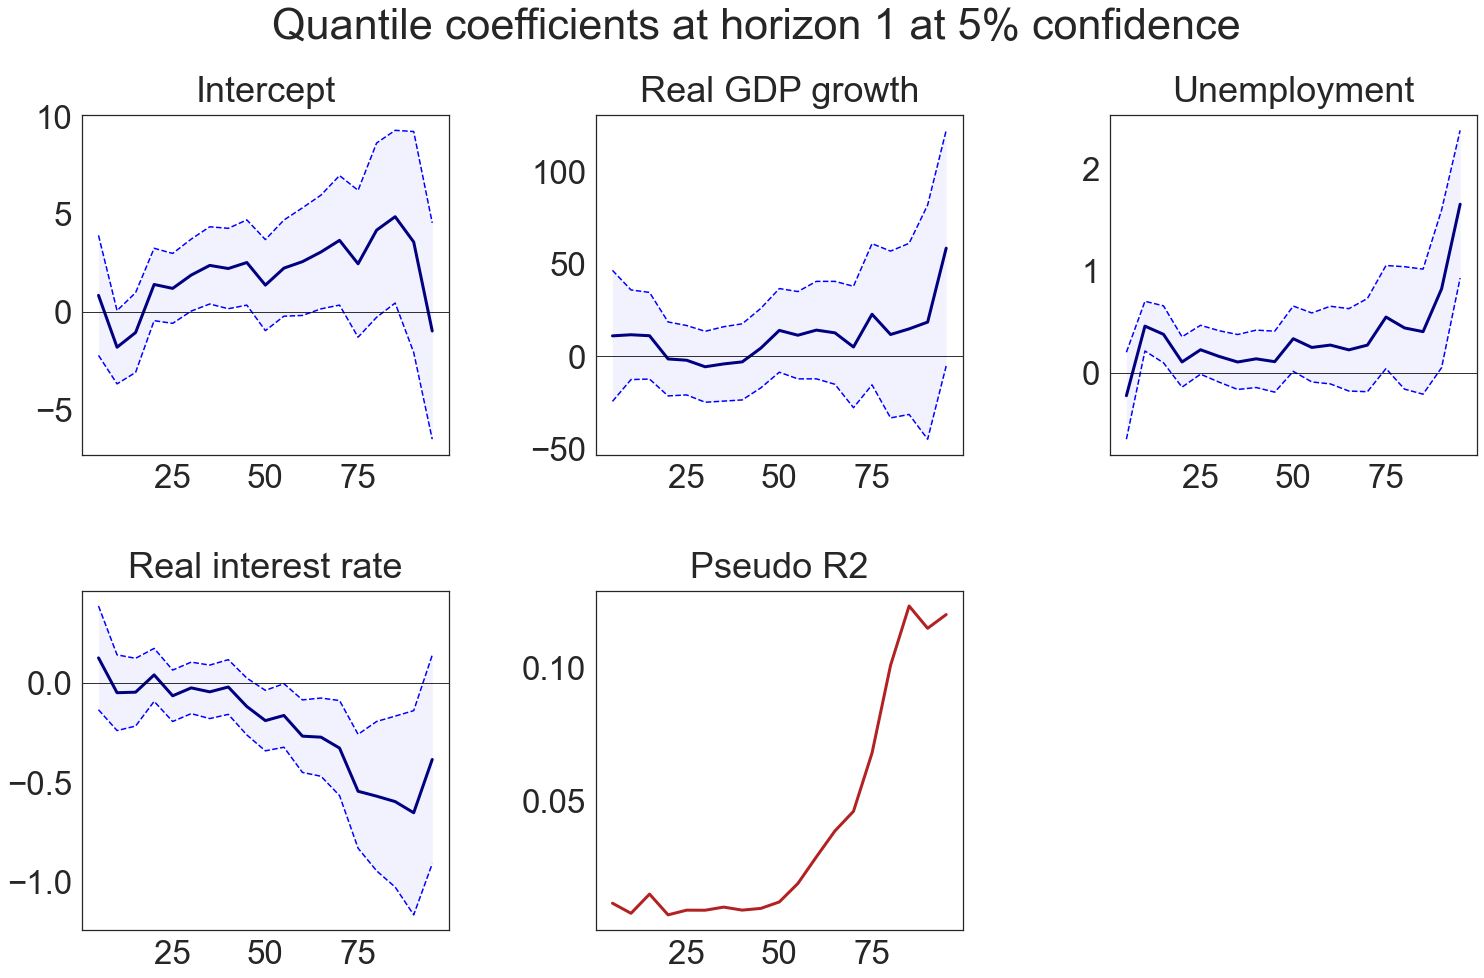

In [8]:
label_d = {'rgdp_growth': 'Real GDP growth',
           'unemployment': 'Unemployment',
           'realint': 'Real interest rate'}

sns.set(style='white', font_scale=3, palette='deep', font='Arial') # Style
qr_fit.plot.coeffs_grid(horizon=1, label_d=label_d)
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()


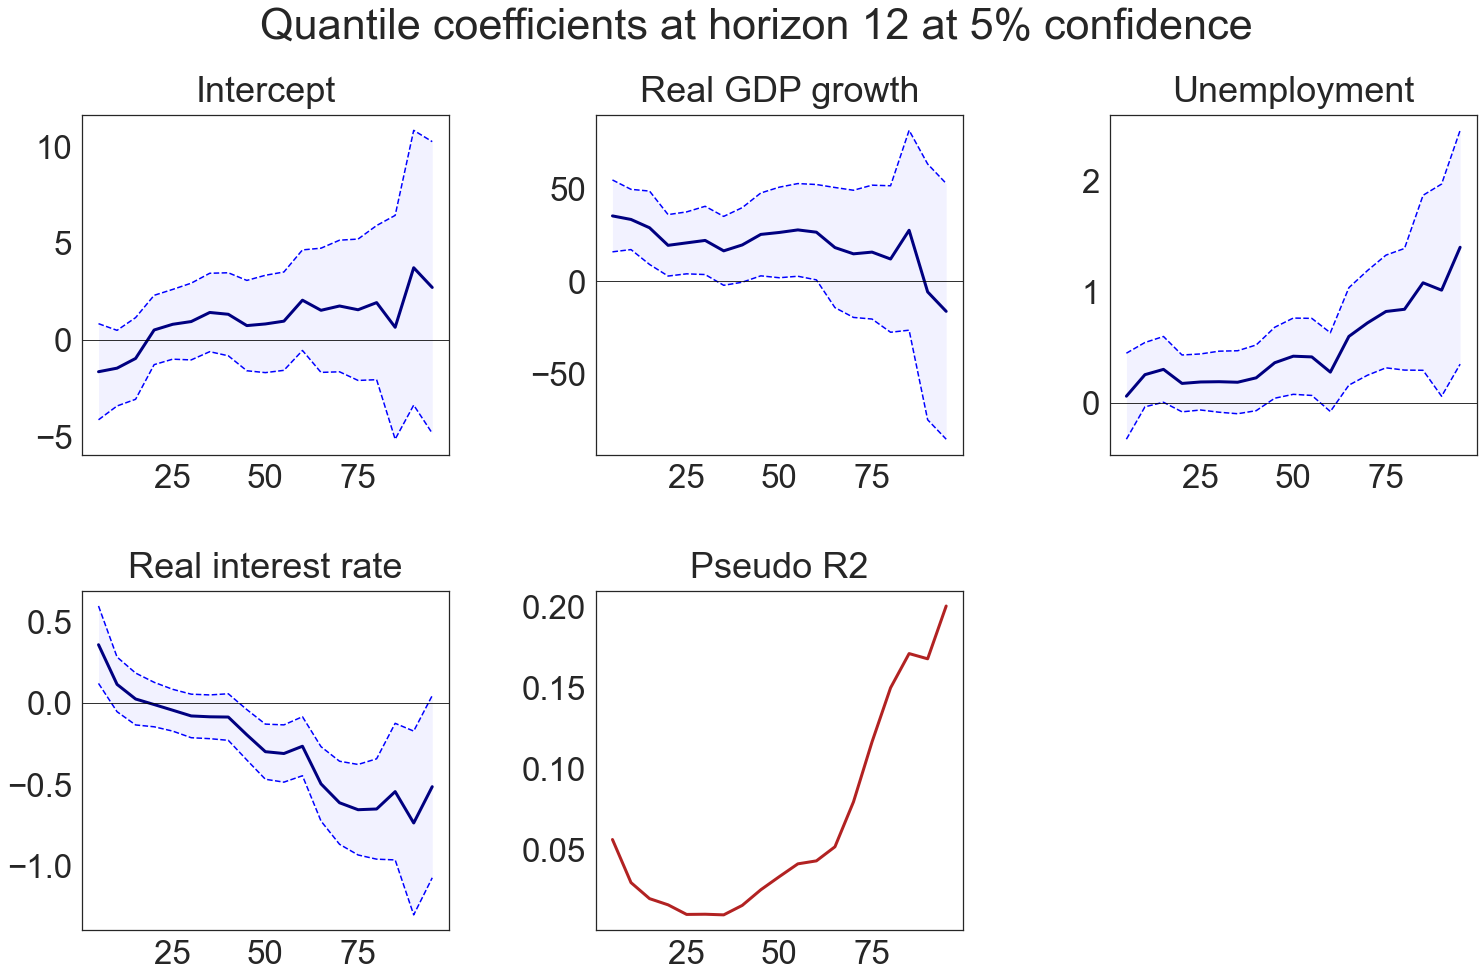

In [9]:
sns.set(style='white', font_scale=3, palette='deep', font='Arial') # Style
qr_fit.plot.coeffs_grid(horizon=12, label_d=label_d)
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()

### Conditional quantiles plot (fitted from quantile regressions)

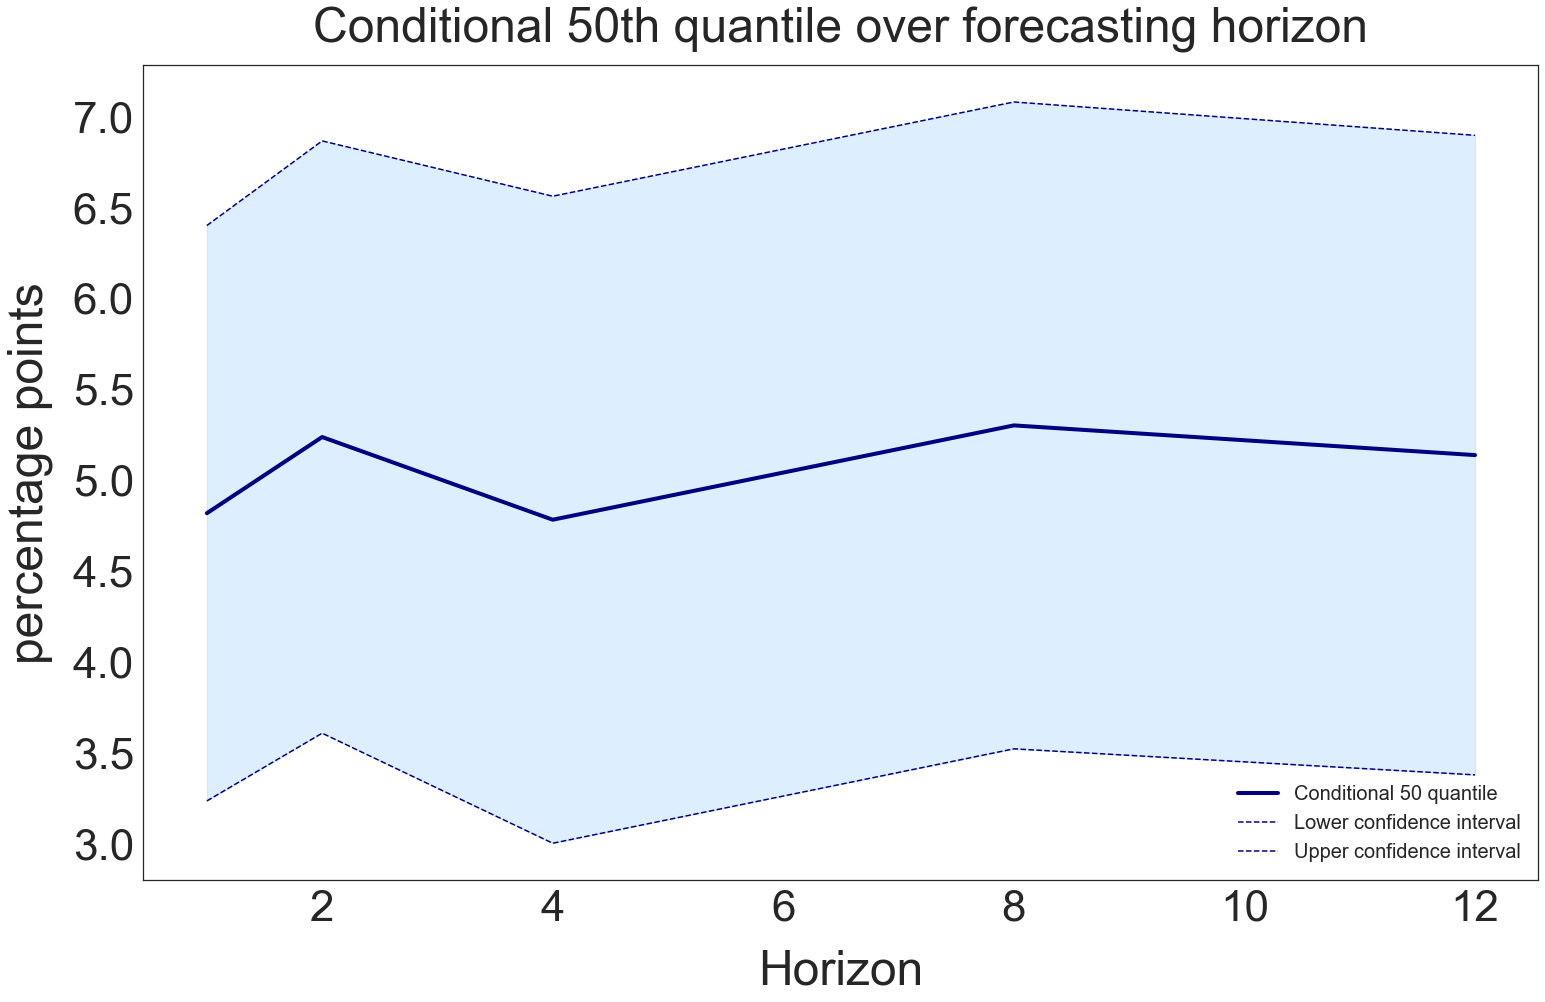

In [10]:
sns.set(style='white', font_scale=4, palette='deep', font='Arial') # Style
qr_proj.plot.fitted_quantile(quantile=0.5, ylabel='percentage points', legendfont=20)
plt.show()

### Fan chart (based on resampled conditional quantiles)

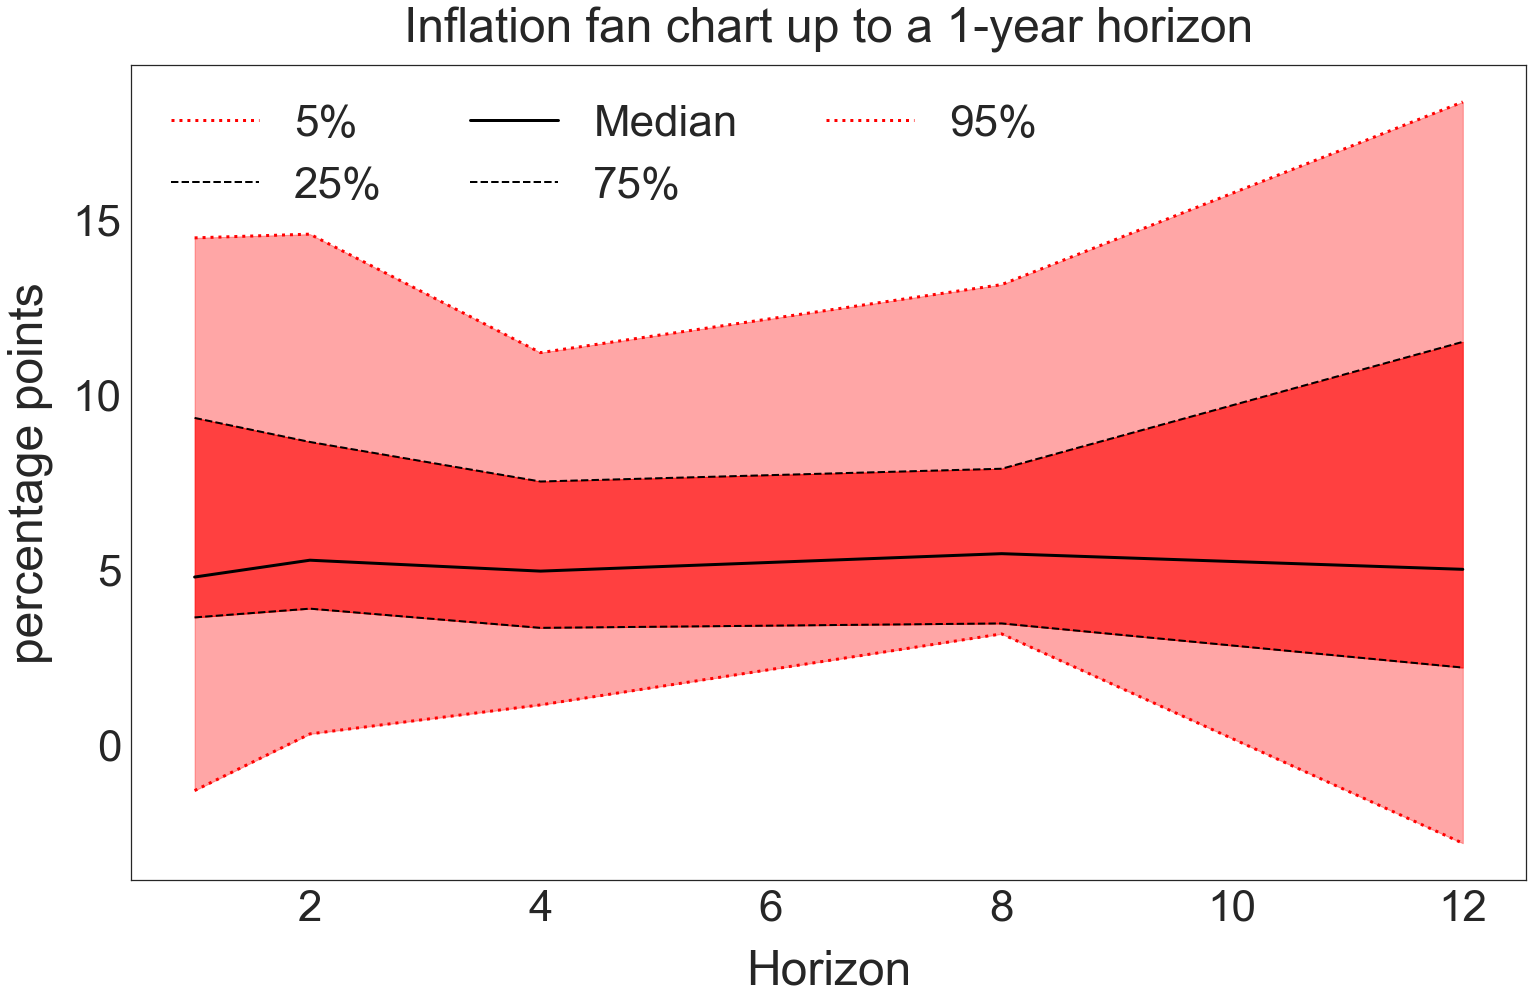

In [12]:
sns.set(style='white', font_scale=4, palette='deep', font='Arial') # Style
qr_proj.plot.fan_chart(title='Inflation fan chart up to a 1-year horizon', ylabel='percentage points', 
                       len_sample=10000, seed=18041202)
plt.show()

#### The file ends here